In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)

iteration:,   0, ps_str, 13042.516593
iteration:,   1, ps_str, 148.081582
iteration:,   2, ps_str, 13045.134180
iteration:,   3, ps_str, 13044.137653
iteration:,   4, ps_str, 13047.635948
iteration:,   5, ps_str, 148.081582
iteration:,   6, ps_str, 148.081582
iteration:,   7, ps_str, 148.081582
iteration:,   8, ps_str, 13042.695492
iteration:,   9, ps_str, 13043.150146
iteration:,  10, ps_str, 148.081582
iteration:,  11, ps_str, 148.081582
iteration:,  12, ps_str, 148.081582
iteration:,  13, ps_str, 148.081582
iteration:,  14, ps_str, 1282.176765
iteration:,  15, ps_str, 1282.269689
iteration:,  16, ps_str, 13045.044700
iteration:,  17, ps_str, 1281.698880
iteration:,  18, ps_str, 513.513271
iteration:,  19, ps_str, 13047.327739
iteration:,  20, ps_str, 148.081582
iteration:,  21, ps_str, 148.081582
iteration:,  22, ps_str, 13043.682978
iteration:,  23, ps_str, 1282.144311
iteration:,  24, ps_str, 148.081582
iteration:,  25, ps_str, 13044.738714
iteration:,  26, ps_str, 148.081582
iter

In [2]:
#Coupling nanosphere scattering spectrum

import meep as mp
import numpy as np
import matplotlib.pyplot as plt


def get_spectrum_coupling(radius, gap, wvl_min, wvl_max):

    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    
    frq_min = 1 / wvl_max
    frq_max = 1 / wvl_min
    frq_cen = 0.5 * (frq_min + frq_max)
    dfrq = frq_max - frq_min
    nfrq = 100
    
    resolution = 8/r
    
    dpml = 2*r
    dair = 2*r
    
    pml_layers = [mp.PML(thickness=dpml)]
    
    symmetries = [mp.Mirror(mp.Y)]
    
    width = 2 * (dpml + dair + r)
    height = 2 * (dpml + dair + 2*r + 0.5*gap)
    cell_size = mp.Vector3(width, width, height)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
    mp.Source(
        mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
        center=mp.Vector3(-0.5 * width + dpml, 0, 0),
        size=mp.Vector3(0, width, height),
        component=mp.Ez)
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        default_material = default_material,
        sources=sources,
        k_point=mp.Vector3(),
        symmetries=symmetries
    )

    f_height = gap + 4*r
    f_width = 2*r

    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, f_width, f_height)),
    )
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, f_width, f_height)),
    )
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(f_width, 0, f_height)),
    )
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(f_width, 0, f_height)),
    )
    box_z1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(z = -0.5*gap +2*r), size=mp.Vector3(f_width, f_width, 0)),
    )
    box_z2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(z = 0.5*gap -2*r), size=mp.Vector3(f_width, f_width, 0)),
    )
    
    sim.run(until_after_sources=10)
    
    freqs = mp.get_flux_freqs(box_x1)
    box_x1_data = sim.get_flux_data(box_x1)
    box_x2_data = sim.get_flux_data(box_x2)
    box_y1_data = sim.get_flux_data(box_y1)
    box_y2_data = sim.get_flux_data(box_y2)
    box_z1_data = sim.get_flux_data(box_z1)
    box_z2_data = sim.get_flux_data(box_z2)
    
    box_x1_flux0 = mp.get_fluxes(box_x1)
    
    sim.reset_meep()


    
    geometry = [
        mp.Sphere(material=Au,
                  center=mp.Vector3(0, 0, 0.5*gap + r),
                  radius=r),
        mp.Sphere(material=Au,
                  center=mp.Vector3(0, 0, -0.5*gap - r),
                  radius=r),
    ]
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        default_material = default_material,
        k_point=mp.Vector3(),
        symmetries=symmetries,
        geometry=geometry,
    )
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, f_width, f_height)),
    )
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, f_width, f_height)),
    )
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(f_width, 0, f_height)),
    )
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(f_width, 0, f_height)),
    )
    box_z1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(z = -0.5*gap +2*r), size=mp.Vector3(f_width, f_width, 0)),
    )
    box_z2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(z = 0.5*gap -2*r), size=mp.Vector3(f_width, f_width, 0)),
    )
    
    sim.load_minus_flux_data(box_x1, box_x1_data)
    sim.load_minus_flux_data(box_x2, box_x2_data)
    sim.load_minus_flux_data(box_y1, box_y1_data)
    sim.load_minus_flux_data(box_y2, box_y2_data)
    sim.load_minus_flux_data(box_z1, box_z1_data)
    sim.load_minus_flux_data(box_z2, box_z2_data)
    
    sim.run(until_after_sources=100)
    
    #flux power through each flux region.
    box_x1_flux = mp.get_fluxes(box_x1)
    box_x2_flux = mp.get_fluxes(box_x2)
    box_y1_flux = mp.get_fluxes(box_y1)
    box_y2_flux = mp.get_fluxes(box_y2)
    box_z1_flux = mp.get_fluxes(box_z1)
    box_z2_flux = mp.get_fluxes(box_z2)
    
    
    #Just want to plot the power of the scattered flux against wavelength
    scatt_flux = (
        np.asarray(box_x1_flux)
        - np.asarray(box_x2_flux)
        + np.asarray(box_y1_flux)
        - np.asarray(box_y2_flux)
        + np.asarray(box_z1_flux)
        - np.asarray(box_z2_flux)
    )

    return scatt_flux, freqs


In [3]:
#Varying Radius

wvl_min = 400E-3
wvl_max = 1000E-3

gap = 50E-3

freq_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
scatt_data = []

r_min =20E-3
r_max =120E-3
radii = np.linspace(r_max,r_min,20)

index = 1

for r in radii:
    print(f"##################### Run {index} Starting #######################")
    scatt_flux, freqs = get_spectrum_coupling(r, gap, wvl_min, wvl_max)
    scatt_data.append(scatt_flux)
    freq_data.append(freqs)

    index+=1

##################### Run 1 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00190401 s
Working in 3D dimensions.
Computational cell is 1.2 x 1.2 x 1.485 with resolution 66.6667
time for set_epsilon = 0.960336 s
-----------
Meep progress: 0.96/16.666666507720947 = 5.8% done in 4.0s, 65.7s to go
on time step 128 (time=0.96), 0.0313798 s/step
Meep progress: 2.73/16.666666507720947 = 16.4% done in 8.0s, 41.0s to go
on time step 364 (time=2.73), 0.0170032 s/step
Meep progress: 4.455/16.666666507720947 = 26.7% done in 12.0s, 33.0s to go
on time step 594 (time=4.455), 0.0174267 s/step
Meep progress: 6.1274999999999995/16.666666507720947 = 36.8% done in 16.1s, 27.6s to go
on time step 817 (time=6.1275), 0.0180127 s/step
Meep progress: 7.9725/16.666666507720947 = 47.8% done in 20.1s, 21.9s to go
on time step 1063 (time=7.9725), 0.0162968 s/step
Meep progress: 9.735/16.666666507720947 = 58.4% do

run 0 finished at t = 16.6725 (2223 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00146008 s
Working in 3D dimensions.
Computational cell is 1.2 x 1.2 x 1.485 with resolution 66.6667
     sphere, center = (0,0,0.145)
          radius 0.12
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.145)
          radius 0.12
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.51277 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.39/106.66666650772095 = 0.4% done in 4.0s, 1092.2s to go
on time step 52 (time=0.39), 0.0770787 s/step
Meep progress: 1.575/106.66666650772095 = 1.5% done in 8.0s, 535.5s to go
on time step 210 (time=1.575), 0.0254243 s/step
Meep progress: 2.7525/106.66666650772095 = 2.6% done in 12.0s, 454.7s to go
on time s

run 0 finished at t = 106.6725 (14223 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.0014379 s
Working in 3D dimensions.
Computational cell is 1.14737 x 1.14737 x 1.41987 with resolution 69.7248
time for set_epsilon = 0.832258 s
-----------
Meep progress: 1.0469736842105264/16.666666507720947 = 6.3% done in 4.0s, 59.8s to go
on time step 146 (time=1.04697), 0.0274462 s/step
Meep progress: 3.0835526315789474/16.666666507720947 = 18.5% done in 8.0s, 35.3s to go
on time step 430 (time=3.08355), 0.0140872 s/step
Meep progress: 4.9408552631578955/16.666666507720947 = 29.6% done in 12.0s, 28.5s to go
on time step 689 (time=4.94086), 0.0154889 s/step
Meep progress: 6.941578947368422/16.666666507720947 = 41.6% done in 16.0s, 22.5s to go
on time step 968 (time=6.94158), 0.014373 s/step
Meep progress: 9.20046052631579/16.666666507720947 = 55.2% done in 20.

run 0 finished at t = 16.672697368421055 (2325 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00133204 s
Working in 3D dimensions.
Computational cell is 1.14737 x 1.14737 x 1.41987 with resolution 69.7248
     sphere, center = (0,0,0.139737)
          radius 0.114737
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.139737)
          radius 0.114737
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.9121 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.559342105263158/106.66666650772095 = 0.5% done in 4.0s, 759.6s to go
on time step 78 (time=0.559342), 0.0513368 s/step
Meep progress: 1.9505263157894739/106.66666650772095 = 1.8% done in 8.0s, 430.0s to go
on time step 272 (time=1.95053), 0.0206459 s/step
Meep progress: 3.399

run 0 finished at t = 106.66940789473685 (14875 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00114679 s
Working in 3D dimensions.
Computational cell is 1.09474 x 1.09474 x 1.36842 with resolution 73.0769
time for set_epsilon = 0.673952 s
-----------
Meep progress: 1.361578947368421/16.666666507720947 = 8.2% done in 4.0s, 45.1s to go
on time step 199 (time=1.36158), 0.0201413 s/step
Meep progress: 3.51/16.666666507720947 = 21.1% done in 8.0s, 30.0s to go
on time step 513 (time=3.51), 0.0127426 s/step
Meep progress: 5.624210526315789/16.666666507720947 = 33.7% done in 12.0s, 23.6s to go
on time step 822 (time=5.62421), 0.0129453 s/step
Meep progress: 7.738421052631578/16.666666507720947 = 46.4% done in 16.0s, 18.5s to go
on time step 1132 (time=7.74526), 0.0129406 s/step
Meep progress: 9.852631578947367/16.666666507720947 = 59.1% done in 20.0s, 1

run 0 finished at t = 16.66736842105263 (2436 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00118685 s
Working in 3D dimensions.
Computational cell is 1.09474 x 1.09474 x 1.36842 with resolution 73.0769
     sphere, center = (0,0,0.134474)
          radius 0.109474
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.134474)
          radius 0.109474
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.08001 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.5063157894736842/106.66666650772095 = 0.5% done in 4.0s, 841.8s to go
on time step 74 (time=0.506316), 0.0542579 s/step
Meep progress: 1.7378947368421052/106.66666650772095 = 1.6% done in 8.0s, 484.1s to go
on time step 254 (time=1.73789), 0.0222343 s/step
Meep progress: 2.94

run 0 finished at t = 106.66842105263157 (15590 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00102997 s
Working in 3D dimensions.
Computational cell is 1.04211 x 1.04211 x 1.30263 with resolution 76.7677
time for set_epsilon = 0.764169 s
-----------
Meep progress: 1.0421052631578949/16.666666507720947 = 6.3% done in 4.0s, 60.1s to go
on time step 160 (time=1.04211), 0.0250567 s/step
Meep progress: 2.8462500000000004/16.666666507720947 = 17.1% done in 8.0s, 38.9s to go
on time step 437 (time=2.84625), 0.0144729 s/step
Meep progress: 4.624342105263159/16.666666507720947 = 27.7% done in 12.0s, 31.3s to go
on time step 710 (time=4.62434), 0.01468 s/step
Meep progress: 6.363355263157896/16.666666507720947 = 38.2% done in 16.0s, 26.0s to go
on time step 977 (time=6.36336), 0.0150061 s/step
Meep progress: 8.115394736842106/16.666666507720947 = 48.7% d

run 0 finished at t = 16.66717105263158 (2559 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.001266 s
Working in 3D dimensions.
Computational cell is 1.04211 x 1.04211 x 1.30263 with resolution 76.7677
     sphere, center = (0,0,0.129211)
          radius 0.104211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.129211)
          radius 0.104211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.4869 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.7946052631578948/106.66666650772095 = 0.7% done in 4.0s, 535.2s to go
on time step 122 (time=0.794605), 0.0329279 s/step
Meep progress: 2.0842105263157897/106.66666650772095 = 2.0% done in 8.0s, 403.0s to go
on time step 320 (time=2.08421), 0.0202737 s/step
Meep progress: 3.4063

run 0 finished at t = 106.67250000000001 (16378 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00122118 s
Working in 3D dimensions.
Computational cell is 0.989474 x 0.989474 x 1.23684 with resolution 80.8511
time for set_epsilon = 0.604699 s
-----------
Meep progress: 1.1626315789473685/16.666666507720947 = 7.0% done in 4.0s, 53.5s to go
on time step 188 (time=1.16263), 0.0213329 s/step
Meep progress: 3.061184210526316/16.666666507720947 = 18.4% done in 8.0s, 35.6s to go
on time step 495 (time=3.06118), 0.0130303 s/step
Meep progress: 4.922631578947368/16.666666507720947 = 29.5% done in 12.0s, 28.7s to go
on time step 796 (time=4.92263), 0.013297 s/step
Meep progress: 6.753157894736842/16.666666507720947 = 40.5% done in 16.0s, 23.5s to go
on time step 1092 (time=6.75316), 0.0135228 s/step
Meep progress: 8.633157894736842/16.666666507720947 = 51.8

run 0 finished at t = 16.672631578947367 (2696 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00145888 s
Working in 3D dimensions.
Computational cell is 0.989474 x 0.989474 x 1.23684 with resolution 80.8511
     sphere, center = (0,0,0.123947)
          radius 0.0989474
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.123947)
          radius 0.0989474
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.14693 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.45144736842105265/106.66666650772095 = 0.4% done in 4.0s, 944.0s to go
on time step 73 (time=0.451447), 0.0549634 s/step
Meep progress: 1.4594736842105263/106.66666650772095 = 1.4% done in 8.0s, 577.9s to go
on time step 236 (time=1.45947), 0.0245602 s/step
Meep progress

run 0 finished at t = 106.67144736842106 (17249 timesteps)
##################### Run 6 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00119615 s
Working in 3D dimensions.
Computational cell is 0.936842 x 0.936842 x 1.17105 with resolution 85.3933
time for set_epsilon = 0.750873 s
-----------
Meep progress: 0.9192763157894737/16.666666507720947 = 5.5% done in 4.0s, 68.7s to go
on time step 157 (time=0.919276), 0.0255342 s/step
Meep progress: 2.6817105263157894/16.666666507720947 = 16.1% done in 8.0s, 41.8s to go
on time step 458 (time=2.68171), 0.0132928 s/step
Meep progress: 4.45/16.666666507720947 = 26.7% done in 12.0s, 33.0s to go
on time step 760 (time=4.45), 0.0132513 s/step
Meep progress: 5.866973684210526/16.666666507720947 = 35.2% done in 16.0s, 29.5s to go
on time step 1003 (time=5.87283), 0.0165316 s/step
Meep progress: 7.143421052631579/16.666666507720947 = 42.9% done in 20.

run 0 finished at t = 16.669934210526314 (2847 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00208807 s
Working in 3D dimensions.
Computational cell is 0.936842 x 0.936842 x 1.17105 with resolution 85.3933
     sphere, center = (0,0,0.118684)
          radius 0.0936842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.118684)
          radius 0.0936842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.09843 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.4508552631578947/106.66666650772095 = 0.4% done in 4.0s, 945.7s to go
on time step 77 (time=0.450855), 0.0521355 s/step
Meep progress: 1.5399342105263158/106.66666650772095 = 1.4% done in 8.0s, 547.4s to go
on time step 263 (time=1.53993), 0.0215158 s/step
Meep progress:

run 0 finished at t = 106.6711842105263 (18218 timesteps)
##################### Run 7 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00133705 s
Working in 3D dimensions.
Computational cell is 0.884211 x 0.884211 x 1.11632 with resolution 90.4762
time for set_epsilon = 0.693066 s
-----------
Meep progress: 1.05/16.666666507720947 = 6.3% done in 4.0s, 59.6s to go
on time step 190 (time=1.05), 0.0210973 s/step
Meep progress: 2.6526315789473682/16.666666507720947 = 15.9% done in 8.0s, 42.3s to go
on time step 480 (time=2.65263), 0.0138134 s/step
Meep progress: 4.177894736842105/16.666666507720947 = 25.1% done in 12.0s, 35.9s to go
on time step 756 (time=4.17789), 0.0145056 s/step
Meep progress: 5.758421052631578/16.666666507720947 = 34.6% done in 16.0s, 30.4s to go
on time step 1042 (time=5.75842), 0.014025 s/step
Meep progress: 7.2671052631578945/16.666666507720947 = 43.6% done in 20.0s,

run 0 finished at t = 16.66736842105263 (3016 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00161195 s
Working in 3D dimensions.
Computational cell is 0.884211 x 0.884211 x 1.11632 with resolution 90.4762
     sphere, center = (0,0,0.113421)
          radius 0.0884211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.113421)
          radius 0.0884211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.63948 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.4807894736842105/106.66666650772095 = 0.5% done in 4.0s, 885.6s to go
on time step 87 (time=0.480789), 0.0460921 s/step
Meep progress: 1.4755263157894736/106.66666650772095 = 1.4% done in 8.0s, 571.5s to go
on time step 267 (time=1.47553), 0.0222559 s/step
Meep progress: 

Meep progress: 106.66342105263158/106.66666650772095 = 100.0% done in 437.5s, 0.0s to go
run 0 finished at t = 106.66894736842104 (19302 timesteps)
##################### Run 8 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00135303 s
Working in 3D dimensions.
Computational cell is 0.831579 x 0.831579 x 1.04987 with resolution 96.2025
time for set_epsilon = 0.718366 s
-----------
Meep progress: 0.8419736842105262/16.666666507720947 = 5.1% done in 4.0s, 75.2s to go
on time step 162 (time=0.841974), 0.0246991 s/step
Meep progress: 2.2764473684210524/16.666666507720947 = 13.7% done in 8.0s, 50.6s to go
on time step 438 (time=2.27645), 0.0145211 s/step
Meep progress: 3.679736842105263/16.666666507720947 = 22.1% done in 12.0s, 42.4s to go
on time step 709 (time=3.68493), 0.0148103 s/step
Meep progress: 5.124605263157894/16.666666507720947 = 30.7% done in 16.0s, 36.1s to go
on time step 987 

run 0 finished at t = 16.667960526315788 (3207 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00127506 s
Working in 3D dimensions.
Computational cell is 0.831579 x 0.831579 x 1.04987 with resolution 96.2025
     sphere, center = (0,0,0.108158)
          radius 0.0831579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.108158)
          radius 0.0831579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.86503 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.37940789473684206/106.66666650772095 = 0.4% done in 4.0s, 1121.0s to go
on time step 73 (time=0.379408), 0.0548177 s/step
Meep progress: 1.2993421052631577/106.66666650772095 = 1.2% done in 8.0s, 650.3s to go
on time step 250 (time=1.29934), 0.0226932 s/step
Meep progres

run 0 finished at t = 106.6707894736842 (20524 timesteps)
##################### Run 9 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00112414 s
Working in 3D dimensions.
Computational cell is 0.778947 x 0.778947 x 0.983421 with resolution 102.703
time for set_epsilon = 0.882254 s
-----------
Meep progress: 0.8325/16.666666507720947 = 5.0% done in 4.0s, 76.1s to go
on time step 171 (time=0.8325), 0.0234039 s/step
Meep progress: 2.22/16.666666507720947 = 13.3% done in 8.0s, 52.1s to go
on time step 456 (time=2.22), 0.0140558 s/step
Meep progress: 3.612368421052632/16.666666507720947 = 21.7% done in 12.0s, 43.5s to go
on time step 742 (time=3.61237), 0.0140567 s/step
Meep progress: 4.970657894736842/16.666666507720947 = 29.8% done in 16.0s, 37.7s to go
on time step 1021 (time=4.97066), 0.0143552 s/step
Meep progress: 6.29/16.666666507720947 = 37.7% done in 20.0s, 33.1s to go
on time step

run 0 finished at t = 16.669473684210526 (3424 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00124407 s
Working in 3D dimensions.
Computational cell is 0.778947 x 0.778947 x 0.983421 with resolution 102.703
     sphere, center = (0,0,0.102895)
          radius 0.0778947
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.102895)
          radius 0.0778947
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.10847 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.43328947368421056/106.66666650772095 = 0.4% done in 4.0s, 984.8s to go
on time step 89 (time=0.433289), 0.0451334 s/step
Meep progress: 1.2998684210526317/106.66666650772095 = 1.2% done in 8.0s, 651.3s to go
on time step 267 (time=1.29987), 0.0225681 s/step
Meep progres

run 0 finished at t = 106.6671052631579 (21910 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.0014441 s
Working in 3D dimensions.
Computational cell is 0.726316 x 0.726316 x 0.926053 with resolution 110.145
time for set_epsilon = 0.68607 s
-----------
Meep progress: 0.7807894736842104/16.666666507720947 = 4.7% done in 4.0s, 81.4s to go
on time step 172 (time=0.780789), 0.0232618 s/step
Meep progress: 1.9701315789473681/16.666666507720947 = 11.8% done in 8.0s, 59.7s to go
on time step 434 (time=1.97013), 0.0152759 s/step
Meep progress: 3.204868421052631/16.666666507720947 = 19.2% done in 12.0s, 50.5s to go
on time step 706 (time=3.20487), 0.0147385 s/step
Meep progress: 4.466842105263157/16.666666507720947 = 26.8% done in 16.0s, 43.7s to go
on time step 984 (time=4.46684), 0.0143977 s/step
Meep progress: 5.697039473684209/16.666666507720947 = 34.

run 0 finished at t = 16.66894736842105 (3672 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00174594 s
Working in 3D dimensions.
Computational cell is 0.726316 x 0.726316 x 0.926053 with resolution 110.145
     sphere, center = (0,0,0.0976316)
          radius 0.0726316
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0976316)
          radius 0.0726316
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.62378 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.3949342105263157/106.66666650772095 = 0.4% done in 4.0s, 1078.0s to go
on time step 87 (time=0.394934), 0.0460494 s/step
Meep progress: 1.148486842105263/106.66666650772095 = 1.1% done in 8.0s, 736.1s to go
on time step 253 (time=1.14849), 0.0241297 s/step
Meep progres

run 0 finished at t = 106.66855263157893 (23498 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00127482 s
Working in 3D dimensions.
Computational cell is 0.673684 x 0.673684 x 0.858947 with resolution 118.75
time for set_epsilon = 0.84787 s
-----------
Meep progress: 0.7073684210526315/16.666666507720947 = 4.2% done in 4.0s, 90.6s to go
on time step 168 (time=0.707368), 0.023896 s/step
Meep progress: 1.9452631578947368/16.666666507720947 = 11.7% done in 8.0s, 60.7s to go
on time step 462 (time=1.94526), 0.013619 s/step
Meep progress: 3.191578947368421/16.666666507720947 = 19.1% done in 12.0s, 50.8s to go
on time step 758 (time=3.19158), 0.0135174 s/step
Meep progress: 4.416842105263158/16.666666507720947 = 26.5% done in 16.0s, 44.5s to go
on time step 1049 (time=4.41684), 0.0137897 s/step
Meep progress: 5.578947368421052/16.666666507720947 = 33.

run 0 finished at t = 16.669473684210526 (3959 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00137997 s
Working in 3D dimensions.
Computational cell is 0.673684 x 0.673684 x 0.858947 with resolution 118.75
     sphere, center = (0,0,0.0923684)
          radius 0.0673684
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0923684)
          radius 0.0673684
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.257 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.3368421052631579/106.66666650772095 = 0.3% done in 4.0s, 1265.2s to go
on time step 80 (time=0.336842), 0.0501037 s/step
Meep progress: 1.111578947368421/106.66666650772095 = 1.0% done in 8.0s, 760.9s to go
on time step 264 (time=1.11158), 0.0217616 s/step
Meep progress:

run 0 finished at t = 106.66947368421053 (25334 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00185299 s
Working in 3D dimensions.
Computational cell is 0.621053 x 0.621053 x 0.791842 with resolution 128.814
time for set_epsilon = 0.923775 s
-----------
Meep progress: 0.5473026315789473/16.666666507720947 = 3.3% done in 4.0s, 118.1s to go
on time step 141 (time=0.547303), 0.0284516 s/step
Meep progress: 1.5138157894736841/16.666666507720947 = 9.1% done in 8.0s, 80.2s to go
on time step 391 (time=1.5177), 0.0160583 s/step
Meep progress: 2.515263157894737/16.666666507720947 = 15.1% done in 12.0s, 67.6s to go
on time step 649 (time=2.51914), 0.0155135 s/step
Meep progress: 3.477894736842105/16.666666507720947 = 20.9% done in 16.0s, 60.7s to go
on time step 897 (time=3.48178), 0.0161321 s/step
Meep progress: 4.459934210526315/16.666666507720947 = 2

run 0 finished at t = 16.6675 (4294 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00115705 s
Working in 3D dimensions.
Computational cell is 0.621053 x 0.621053 x 0.791842 with resolution 128.814
     sphere, center = (0,0,0.0871053)
          radius 0.0621053
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0871053)
          radius 0.0621053
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.97562 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.2872368421052631/106.66666650772095 = 0.3% done in 4.0s, 1493.7s to go
on time step 74 (time=0.287237), 0.0545062 s/step
Meep progress: 0.9820394736842105/106.66666650772095 = 0.9% done in 8.0s, 864.9s to go
on time step 253 (time=0.982039), 0.0223605 s/step
Meep progress: 1.680

run 0 finished at t = 106.66967105263157 (27481 timesteps)
##################### Run 13 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00113392 s
Working in 3D dimensions.
Computational cell is 0.568421 x 0.568421 x 0.731842 with resolution 140.741
time for set_epsilon = 0.812243 s
-----------
Meep progress: 0.5613157894736841/16.666666507720947 = 3.4% done in 4.0s, 115.1s to go
on time step 158 (time=0.561316), 0.0253896 s/step
Meep progress: 1.5276315789473682/16.666666507720947 = 9.2% done in 8.0s, 79.5s to go
on time step 430 (time=1.52763), 0.0147433 s/step
Meep progress: 2.4548684210526313/16.666666507720947 = 14.7% done in 12.0s, 69.7s to go
on time step 691 (time=2.45487), 0.0153623 s/step
Meep progress: 3.321710526315789/16.666666507720947 = 19.9% done in 16.0s, 64.4s to go
on time step 935 (time=3.32171), 0.016405 s/step
Meep progress: 4.241842105263157/16.666666507720947 = 

run 0 finished at t = 16.66894736842105 (4692 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00104904 s
Working in 3D dimensions.
Computational cell is 0.568421 x 0.568421 x 0.731842 with resolution 140.741
     sphere, center = (0,0,0.0818421)
          radius 0.0568421
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0818421)
          radius 0.0568421
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.02407 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.29486842105263156/106.66666650772095 = 0.3% done in 4.0s, 1450.9s to go
on time step 83 (time=0.294868), 0.0484603 s/step
Meep progress: 0.9236842105263157/106.66666650772095 = 0.9% done in 8.0s, 920.0s to go
on time step 260 (time=0.923684), 0.0226717 s/step
Meep prog

run 0 finished at t = 106.66776315789473 (30025 timesteps)
##################### Run 14 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00102901 s
Working in 3D dimensions.
Computational cell is 0.515789 x 0.515789 x 0.670526 with resolution 155.102
time for set_epsilon = 0.941561 s
-----------
Meep progress: 0.5576973684210526/16.666666507720947 = 3.3% done in 4.0s, 115.7s to go
on time step 173 (time=0.557697), 0.0231528 s/step
Meep progress: 1.3926315789473682/16.666666507720947 = 8.4% done in 8.0s, 87.9s to go
on time step 432 (time=1.39263), 0.0154587 s/step
Meep progress: 2.250131578947368/16.666666507720947 = 13.5% done in 12.0s, 77.0s to go
on time step 698 (time=2.25013), 0.0150627 s/step
Meep progress: 3.1656578947368414/16.666666507720947 = 19.0% done in 16.0s, 68.4s to go
on time step 982 (time=3.16566), 0.0141231 s/step
Meep progress: 4.0102631578947365/16.666666507720947 

run 0 finished at t = 16.669671052631575 (5171 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00147009 s
Working in 3D dimensions.
Computational cell is 0.515789 x 0.515789 x 0.670526 with resolution 155.102
     sphere, center = (0,0,0.0765789)
          radius 0.0515789
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0765789)
          radius 0.0515789
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.00353 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.24822368421052626/106.66666650772095 = 0.2% done in 4.0s, 1718.2s to go
on time step 77 (time=0.248224), 0.0520508 s/step
Meep progress: 0.818815789473684/106.66666650772095 = 0.8% done in 8.0s, 1035.9s to go
on time step 254 (time=0.818816), 0.0226251 s/step
Meep pro

run 0 finished at t = 106.66848684210524 (33089 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00125909 s
Working in 3D dimensions.
Computational cell is 0.463158 x 0.463158 x 0.607895 with resolution 172.727
time for set_epsilon = 0.967545 s
-----------
Meep progress: 0.44/16.666666507720947 = 2.6% done in 4.0s, 147.7s to go
on time step 152 (time=0.44), 0.0263526 s/step
Meep progress: 1.230263157894737/16.666666507720947 = 7.4% done in 8.0s, 100.5s to go
on time step 426 (time=1.23316), 0.0146512 s/step
Meep progress: 2.0263157894736845/16.666666507720947 = 12.2% done in 12.0s, 86.9s to go
on time step 700 (time=2.02632), 0.0145993 s/step
Meep progress: 2.7963157894736845/16.666666507720947 = 16.8% done in 16.0s, 79.5s to go
on time step 966 (time=2.79632), 0.0150477 s/step
Meep progress: 3.6126315789473686/16.666666507720947 = 21.7% done in 2

run 0 finished at t = 16.667894736842108 (5758 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00110292 s
Working in 3D dimensions.
Computational cell is 0.463158 x 0.463158 x 0.607895 with resolution 172.727
     sphere, center = (0,0,0.0713158)
          radius 0.0463158
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0713158)
          radius 0.0463158
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.04198 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.2286842105263158/106.66666650772095 = 0.2% done in 4.0s, 1871.6s to go
on time step 79 (time=0.228684), 0.0509031 s/step
Meep progress: 0.7294736842105264/106.66666650772095 = 0.7% done in 8.0s, 1165.5s to go
on time step 252 (time=0.729474), 0.0231405 s/step
Meep pro

run 0 finished at t = 106.66815789473685 (36849 timesteps)
##################### Run 16 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.0017271 s
Working in 3D dimensions.
Computational cell is 0.410526 x 0.410526 x 0.543947 with resolution 194.872
time for set_epsilon = 0.858042 s
-----------
Meep progress: 0.3925657894736842/16.666666507720947 = 2.4% done in 4.0s, 166.2s to go
on time step 153 (time=0.392566), 0.0262123 s/step
Meep progress: 1.0571052631578948/16.666666507720947 = 6.3% done in 8.0s, 118.3s to go
on time step 413 (time=1.05967), 0.0154392 s/step
Meep progress: 1.731907894736842/16.666666507720947 = 10.4% done in 12.0s, 103.7s to go
on time step 676 (time=1.73447), 0.0152585 s/step
Meep progress: 2.4349342105263156/16.666666507720947 = 14.6% done in 16.0s, 93.7s to go
on time step 950 (time=2.4375), 0.0146463 s/step
Meep progress: 3.099473684210526/16.666666507720947 =

run 0 finished at t = 16.667368421052632 (6496 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00116992 s
Working in 3D dimensions.
Computational cell is 0.410526 x 0.410526 x 0.543947 with resolution 194.872
     sphere, center = (0,0,0.0660526)
          radius 0.0410526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0660526)
          radius 0.0410526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.08301 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.195/106.66666650772095 = 0.2% done in 4.0s, 2195.1s to go
on time step 76 (time=0.195), 0.0528994 s/step
Meep progress: 0.6440131578947368/106.66666650772095 = 0.6% done in 8.0s, 1323.8s to go
on time step 251 (time=0.644013), 0.0229744 s/step
Meep progress: 1.0981578

run 0 finished at t = 106.66756578947368 (41573 timesteps)
##################### Run 17 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00133991 s
Working in 3D dimensions.
Computational cell is 0.357895 x 0.357895 x 0.478684 with resolution 223.529
time for set_epsilon = 0.812385 s
-----------
Meep progress: 0.3534210526315789/16.666666507720947 = 2.1% done in 4.0s, 184.6s to go
on time step 158 (time=0.353421), 0.02532 s/step
Meep progress: 0.9349999999999999/16.666666507720947 = 5.6% done in 8.0s, 134.6s to go
on time step 418 (time=0.935), 0.015391 s/step
Meep progress: 1.5478947368421052/16.666666507720947 = 9.3% done in 12.0s, 117.3s to go
on time step 692 (time=1.54789), 0.0146345 s/step
Meep progress: 2.129473684210526/16.666666507720947 = 12.8% done in 16.0s, 109.4s to go
on time step 952 (time=2.12947), 0.0154329 s/step
Meep progress: 2.7446052631578945/16.666666507720947 = 1

run 0 finished at t = 16.66671052631579 (7451 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.0011301 s
Working in 3D dimensions.
Computational cell is 0.357895 x 0.357895 x 0.478684 with resolution 223.529
     sphere, center = (0,0,0.0607895)
          radius 0.0357895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0607895)
          radius 0.0357895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.96475 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16999999999999998/106.66666650772095 = 0.2% done in 4.0s, 2508.9s to go
on time step 76 (time=0.17), 0.0526988 s/step
Meep progress: 0.5703947368421052/106.66666650772095 = 0.5% done in 8.0s, 1490.0s to go
on time step 255 (time=0.570395), 0.022373 s/step
Meep progress:

run 0 finished at t = 106.6682894736842 (47687 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00128102 s
Working in 3D dimensions.
Computational cell is 0.305263 x 0.305263 x 0.415921 with resolution 262.069
time for set_epsilon = 0.999044 s
-----------
Meep progress: 0.23848684210526314/16.666666507720947 = 1.4% done in 4.0s, 275.8s to go
on time step 125 (time=0.238487), 0.0320294 s/step
Meep progress: 0.7021052631578947/16.666666507720947 = 4.2% done in 8.0s, 182.2s to go
on time step 368 (time=0.702105), 0.0164867 s/step
Meep progress: 1.1752631578947368/16.666666507720947 = 7.1% done in 12.0s, 158.4s to go
on time step 616 (time=1.17526), 0.0161514 s/step
Meep progress: 1.6522368421052631/16.666666507720947 = 9.9% done in 16.0s, 145.6s to go
on time step 866 (time=1.65224), 0.0160248 s/step
Meep progress: 2.121578947368421/16.66666650772094

run 0 finished at t = 16.667368421052632 (8736 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00156212 s
Working in 3D dimensions.
Computational cell is 0.305263 x 0.305263 x 0.415921 with resolution 262.069
     sphere, center = (0,0,0.0555263)
          radius 0.0305263
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0555263)
          radius 0.0305263
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.59035 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.10302631578947367/106.66666650772095 = 0.1% done in 4.0s, 4148.6s to go
on time step 54 (time=0.103026), 0.0742787 s/step
Meep progress: 0.4006578947368421/106.66666650772095 = 0.4% done in 8.0s, 2127.1s to go
on time step 210 (time=0.400658), 0.0256939 s/step
Meep pr

Meep progress: 106.65131578947368/106.66666650772095 = 100.0% done in 1307.7s, 0.2s to go
run 0 finished at t = 106.66848684210525 (55909 timesteps)
##################### Run 19 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00121093 s
Working in 3D dimensions.
Computational cell is 0.252632 x 0.252632 x 0.353684 with resolution 316.667
time for set_epsilon = 1.00702 s
-----------
Meep progress: 0.23526315789473679/16.666666507720947 = 1.4% done in 4.0s, 280.0s to go
on time step 149 (time=0.235263), 0.0269062 s/step
Meep progress: 0.6457894736842104/16.666666507720947 = 3.9% done in 8.0s, 198.8s to go
on time step 409 (time=0.645789), 0.0154002 s/step
Meep progress: 1.0531578947368418/16.666666507720947 = 6.3% done in 12.0s, 178.1s to go
on time step 667 (time=1.05316), 0.0155084 s/step
Meep progress: 1.458947368421052/16.666666507720947 = 8.8% done in 16.0s, 167.0s to go
on time ste

run 0 finished at t = 16.667368421052625 (10556 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00124097 s
Working in 3D dimensions.
Computational cell is 0.252632 x 0.252632 x 0.353684 with resolution 316.667
     sphere, center = (0,0,0.0502632)
          radius 0.0252632
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0502632)
          radius 0.0252632
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.23584 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.1089473684210526/106.66666650772095 = 0.1% done in 4.0s, 3929.5s to go
on time step 69 (time=0.108947), 0.05823 s/step
Meep progress: 0.3726315789473683/106.66666650772095 = 0.3% done in 8.0s, 2291.3s to go
on time step 236 (time=0.372632), 0.0240338 s/step
Meep prog

run 0 finished at t = 106.6673684210526 (67556 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00127292 s
Working in 3D dimensions.
Computational cell is 0.2 x 0.2 x 0.29 with resolution 400
time for set_epsilon = 0.939639 s
-----------
Meep progress: 0.17375000000000002/16.666666507720947 = 1.0% done in 4.0s, 380.9s to go
on time step 139 (time=0.17375), 0.0288666 s/step
Meep progress: 0.49625/16.666666507720947 = 3.0% done in 8.0s, 261.4s to go
on time step 397 (time=0.49625), 0.0155435 s/step
Meep progress: 0.8125/16.666666507720947 = 4.9% done in 12.0s, 234.6s to go
on time step 651 (time=0.81375), 0.015789 s/step
Meep progress: 1.125/16.666666507720947 = 6.8% done in 16.0s, 221.4s to go
on time step 901 (time=1.12625), 0.0160133 s/step
Meep progress: 1.44875/16.666666507720947 = 8.7% done in 20.0s, 210.5s to go
on time step 1160 (time=1.45),

run 0 finished at t = 16.6675 (13334 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00118303 s
Working in 3D dimensions.
Computational cell is 0.2 x 0.2 x 0.29 with resolution 400
     sphere, center = (0,0,0.045)
          radius 0.02
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.045)
          radius 0.02
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.26238 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.07/106.66666650772095 = 0.1% done in 4.0s, 6109.5s to go
on time step 56 (time=0.07), 0.0716459 s/step
Meep progress: 0.2775/106.66666650772095 = 0.3% done in 8.0s, 3075.6s to go
on time step 222 (time=0.2775), 0.0241538 s/step
Meep progress: 0.48125/106.66666650772095 = 0.5% done in 12.0s, 2653.8s to go
on time 

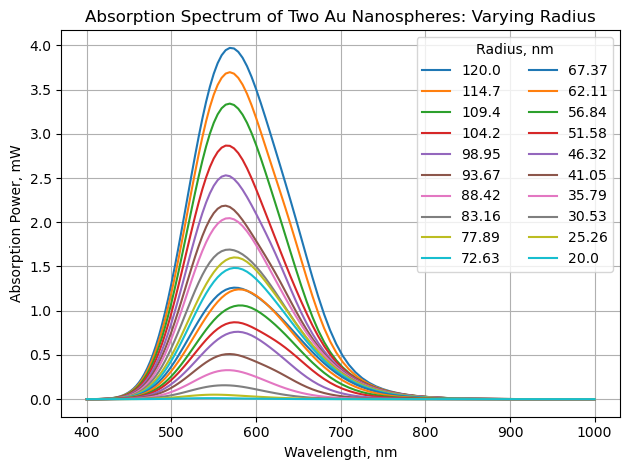

[1.20000000e-01 5.68965517e+02]
[1.14736842e-01 5.68965517e+02]
[1.09473684e-01 5.68965517e+02]
[1.04210526e-01 5.64102564e+02]
[9.89473684e-02 5.64102564e+02]
[9.36842105e-02 5.64102564e+02]
[8.84210526e-02 5.68965517e+02]
[8.31578947e-02 5.68965517e+02]
[7.78947368e-02 5.73913043e+02]
[7.26315789e-02 5.73913043e+02]
[6.73684211e-02 5.73913043e+02]
[6.21052632e-02 5.78947368e+02]
[5.68421053e-02 5.78947368e+02]
[5.15789474e-02 5.73913043e+02]
[4.63157895e-02 5.78947368e+02]
[4.10526316e-02 5.68965517e+02]
[3.57894737e-02 5.68965517e+02]
[3.05263158e-02 5.64102564e+02]
[2.52631579e-02 5.50000000e+02]
[2.00000000e-02 5.45454545e+02]
[1.2e-01 1.0e+03]
[1.14736842e-01 1.00000000e+03]
[1.09473684e-01 1.00000000e+03]
[1.04210526e-01 1.00000000e+03]
[9.89473684e-02 1.00000000e+03]
[9.36842105e-02 1.00000000e+03]
[8.84210526e-02 1.00000000e+03]
[8.31578947e-02 1.00000000e+03]
[7.78947368e-02 1.00000000e+03]
[7.26315789e-02 1.00000000e+03]
[6.73684211e-02 1.00000000e+03]
[6.21052632e-02 1.0000

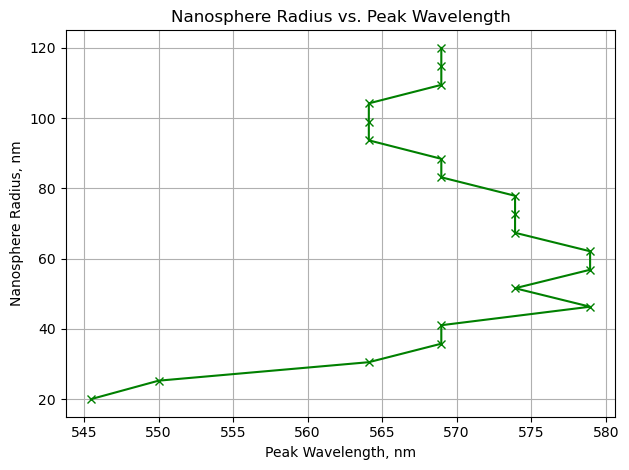

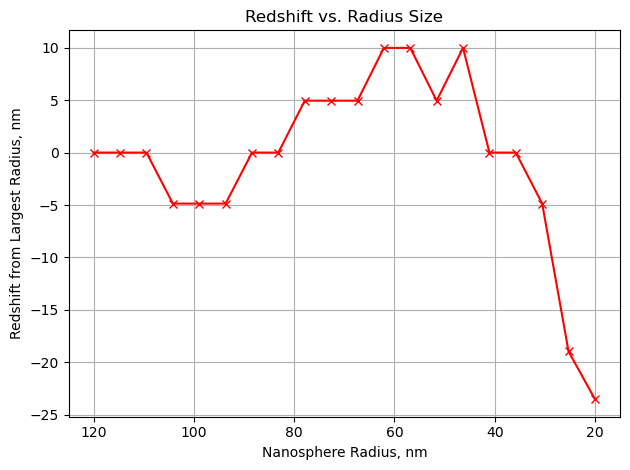

In [10]:
max_wvls_ab = [] #to store the wavelength value where the peak occurs
max_wvls_sc = []
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.
#

for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    radius = radii[index]
    
    plt.plot(1E3/freqs, -1*scatt_flux*1E3, "-", label=f"{str(1E3*round(float(radius),5))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, mW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly

    plt.legend(loc="upper right", title = "Radius, nm", ncol=2)
    plt.title("Absorption Spectrum of Two Au Nanospheres: Varying Radius")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    
    max_wvl_ab = 1E3/freqs[np.argmin(scatt_flux)]
    
    max_wvl_sc = 1E3/freqs[np.argmax(scatt_flux)]
    
    max_wvls_ab.append([radius, max_wvl_ab])
    max_wvls_sc.append([radius, max_wvl_sc])

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="Absorption Spectrum of Two Au Nanospheres: Varying Radius",
            dpi=150, 
            bbox_inches="tight")
plt.show()
max_wvls_ab = np.asarray(max_wvls_ab)
max_wvls_sc = np.asarray(max_wvls_sc)

for row in max_wvls_ab:
    print(row)

for row in max_wvls_sc:
    print(row)

#plot curvature vs. peak position

plt.plot(max_wvls_ab[:,1], 1E3*max_wvls_ab[:,0], "gx-", label="Absorption Peaks")
#plt.plot(max_wvls_sc[:,1], 1E3*max_wvls_sc[:,0], "x-",c="orange", label="Scattering Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanosphere Radius, nm")
plt.title("Nanosphere Radius vs. Peak Wavelength")
plt.tight_layout()
#plt.legend(loc="upper center")
plt.savefig(fname="Au Nanosphere Radius vs Peak Wavelength",
            dpi=150, 
bbox_inches="tight")
plt.show()

#Plot of redshift vs. AR

redshift_ab = max_wvls_ab[:,1]-max_wvls_ab[0,1] #peak position minus longest cylinder position
redshift_sc = max_wvls_sc[:,1]-max_wvls_sc[0,1]

plt.plot(1E3*radii, redshift_ab, "rx-", label="Absorption Peak")
#plt.plot(1E3*radii, redshift_sc, "bx-", label="Scattering Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Nanosphere Radius, nm")
plt.ylabel("Redshift from Largest Radius, nm")
plt.title("Redshift vs. Radius Size")
plt.tight_layout()
#plt.legend(loc="upper right")
plt.savefig(fname="2 Redshift vs Radius Size",
            dpi=150, 
            bbox_inches="tight")
plt.show()



In [ ]:
# Varying Gap Size

wvl_min = 400E-3
wvl_max = 800E-3

r = 50E-3

freq_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
scatt_data = []


gap_min =7E-3
gap_max =120E-3
gaps = np.linspace(gap_max,gap_min,20)

index = 1

for gap in gaps:
    print(f"##################### Run {index} Starting #######################")
    scatt_flux, freqs = get_spectrum_coupling(r, gap, wvl_min, wvl_max)
    scatt_data.append(scatt_flux)
    freq_data.append(freqs)
    
    index += 1


##################### Run 1 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00172997 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 0.720833 with resolution 240
time for set_epsilon = 3.25244 s
-----------
Meep progress: 0.0020833333333333333/18.0 = 0.0% done in 5.0s, 43251.4s to go
on time step 1 (time=0.00208333), 5.00665 s/step
Meep progress: 0.17083333333333334/18.0 = 0.9% done in 9.0s, 943.4s to go
on time step 82 (time=0.170833), 0.0497751 s/step
Meep progress: 0.34791666666666665/18.0 = 1.9% done in 13.0s, 662.1s to go
on time step 167 (time=0.347917), 0.0471714 s/step
Meep progress: 0.5166666666666666/18.0 = 2.9% done in 17.1s, 577.4s to go
on time step 248 (time=0.516667), 0.0495235 s/step
Meep progress: 0.6895833333333333/18.0 = 3.8% done in 21.1s, 529.8s to go
on time step 331 (time=0.689583), 0.0487125 s/step
Meep progress: 0.8624999999999999/18.0 = 4.8% done

run 0 finished at t = 18.0 (8640 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00139093 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 0.720833 with resolution 240
     sphere, center = (0,0,0.11)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.11)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 6.27376 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.0020833333333333333/108.0 = 0.0% done in 4.5s, 232816.8s to go
on time step 1 (time=0.00208333), 4.49126 s/step
Meep progress: 0.13541666666666666/108.0 = 0.1% done in 8.5s, 6801.2s to go
on time step 65 (time=0.135417), 0.0632281 s/step
Meep progress: 0.26875/108.0 = 0.2% done in 12.6s, 5037.1s to go
on time step 

run 0 finished at t = 108.0 (51840 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00198388 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 0.7125 with resolution 240
time for set_epsilon = 2.81454 s
-----------
Meep progress: 0.0020833333333333333/18.0 = 0.0% done in 4.5s, 39040.9s to go
on time step 1 (time=0.00208333), 4.51933 s/step
Meep progress: 0.18333333333333332/18.0 = 1.0% done in 8.5s, 829.1s to go
on time step 88 (time=0.183333), 0.0461055 s/step
Meep progress: 0.36666666666666664/18.0 = 2.0% done in 12.6s, 603.6s to go
on time step 176 (time=0.366667), 0.0456666 s/step
Meep progress: 0.54375/18.0 = 3.0% done in 16.6s, 533.0s to go
on time step 261 (time=0.54375), 0.0476394 s/step
Meep progress: 0.725/18.0 = 4.0% done in 20.6s, 491.4s to go
on time step 348 (time=0.725), 0.0462013 s/step
Meep progress: 0.9041666666666667/

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00131702 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 0.7125 with resolution 240
     sphere, center = (0,0,0.107026)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.107026)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 4.99871 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.0020833333333333333/108.0 = 0.0% done in 5.3s, 276071.5s to go
on time step 1 (time=0.00208333), 5.32567 s/step
Meep progress: 0.13333333333333333/108.0 = 0.1% done in 9.3s, 7555.4s to go
on time step 64 (time=0.133333), 0.063698 s/step
Meep progress: 0.275/108.0 = 0.3% done in 13.4s, 5247.5s to go
on time step 132 (time=0.275), 0.0596452 s/step
Meep p

##################### Run 3 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00136495 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 0.708333 with resolution 240
time for set_epsilon = 3.25923 s
-----------
Meep progress: 0.0020833333333333333/18.0 = 0.0% done in 4.5s, 39086.2s to go
on time step 1 (time=0.00208333), 4.52455 s/step
Meep progress: 0.21875/18.0 = 1.2% done in 8.5s, 694.9s to go
on time step 105 (time=0.21875), 0.0386893 s/step
Meep progress: 0.4354166666666667/18.0 = 2.4% done in 12.6s, 506.9s to go
on time step 209 (time=0.435417), 0.0386193 s/step
Meep progress: 0.6645833333333333/18.0 = 3.7% done in 16.6s, 432.9s to go
on time step 319 (time=0.664583), 0.0366377 s/step
Meep progress: 0.8729166666666667/18.0 = 4.8% done in 20.6s, 404.4s to go
on time step 419 (time=0.872917), 0.0401148 s/step
Meep progress: 1.0583333333333333/18.0 = 5.9% done in 24.6s, 39

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.002069 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 0.708333 with resolution 240
     sphere, center = (0,0,0.104053)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.104053)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 7.11404 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.0020833333333333333/108.0 = 0.0% done in 5.0s, 256631.9s to go
on time step 1 (time=0.00208333), 4.95812 s/step
Meep progress: 0.13541666666666666/108.0 = 0.1% done in 9.0s, 7169.9s to go
on time step 65 (time=0.135417), 0.0628618 s/step
Meep progress: 0.275/108.0 = 0.3% done in 13.0s, 5101.6s to go
on time step 132 (time=0.275), 0.0600174 s/step
Meep 

run 0 finished at t = 108.0 (51840 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00381589 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 0.704167 with resolution 240
time for set_epsilon = 2.83417 s
-----------


In [ ]:
max_wvls_ab = [] #to store the wavelength value where the peak occurs
max_wvls_sc = []
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.
#

for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    gap = gaps[index]
    
    plt.plot(1E3/freqs, -1*scatt_flux*1E3, "-", label=f"{str(1E3*round(float(gap),5))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, mW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly

    plt.legend(loc="upper right", title = "Gap Size, nm", ncol=2)
    plt.title("Absorption Spectrum of Two Au Nanospheres: Varying Gap Size")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    
    max_wvl_ab = 1E3/freqs[np.argmin(scatt_flux)]
    
    max_wvl_sc = 1E3/freqs[np.argmax(scatt_flux)]
    
    max_wvls_ab.append([gap, max_wvl_ab])
    max_wvls_sc.append([gap, max_wvl_sc])

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="Absorption Spectrum of Two Au Nanospheres: Varying Gap",
            dpi=150, 
            bbox_inches="tight")
plt.show()
max_wvls_ab = np.asarray(max_wvls_ab)
max_wvls_sc = np.asarray(max_wvls_sc)

for row in max_wvls_ab:
    print(row)

for row in max_wvls_sc:
    print(row)

#plot curvature vs. peak position

plt.plot(max_wvls_ab[:,1], 1E3*max_wvls_ab[:,0], "gx-", label="Absorption Peaks")
#plt.plot(max_wvls_sc[:,1], 1E3*max_wvls_sc[:,0], "x-",c="orange", label="Scattering Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Gap Size, nm")
plt.title("Gap Size vs. Peak Wavelength")
plt.tight_layout()
#plt.legend(loc="upper center")
plt.savefig(fname="Gap vs Peak Wavelength",
            dpi=150, 
            bbox_inches="tight")
plt.show()

#Plot of redshift vs. AR

redshift_ab = max_wvls_ab[:,1]-max_wvls_ab[0,1] #peak position minus longest cylinder position
redshift_sc = max_wvls_sc[:,1]-max_wvls_sc[0,1]

plt.plot(1E3*gaps, redshift_ab, "rx-", label="Absorption Peak")
#plt.plot(1E3*gaps, redshift_sc, "bx-", label="Scattering Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Gap Size, nm")
plt.ylabel("Redshift from Largest Gap Size, nm")
plt.title("Redshift vs. Gap Size")
plt.tight_layout()
#plt.legend(loc="upper right")
plt.savefig(fname="Redshift vs Gap Size",
            dpi=150, 
            bbox_inches="tight")
plt.show()

